<a href="https://colab.research.google.com/github/qkrcks0/Image_Recognition_Attraction_model/blob/main/Image_Recognition_Attraction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -q /content/drive/MyDrive/kaggle_celeb_faces_dataset.zip -d kaggle

replace kaggle/img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
import glob
import os
import pandas as pd
import cv2
from keras.utils import np_utils
from tqdm.notebook import tqdm

In [2]:
img_dir = os.path.join("/content/kaggle/img_align_celeba/img_align_celeba/")
img_dir

'/content/kaggle/img_align_celeba/img_align_celeba/'

In [3]:
img_paths = os.listdir(img_dir)
img_paths.sort()
img_paths[:5], len(img_paths)

(['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg'],
 202599)

In [4]:
attr = pd.read_csv("/content/kaggle/list_attr_celeba.csv")
attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [5]:
attr.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [6]:
partition_df = pd.read_csv("/content/kaggle/list_eval_partition.csv")
partition_df

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,2
202595,202596.jpg,2
202596,202597.jpg,2
202597,202598.jpg,2


In [7]:
attraction_df = pd.DataFrame(attr["image_id"])
attraction_df["Attractive"] = attr["Attractive"]
attraction_df["Gender"] = attr["Male"]
attraction_df.loc[attraction_df.Gender == -1, "Gender"] = 0
attraction_df.loc[attraction_df.Attractive == -1, "Attractive"] = 0
attraction_df["Partition"] = partition_df["partition"]
attraction_df.head()

,image_id,Attractive,Gender,Partition
0,000001.jpg,1,0,0
1,000002.jpg,0,0,0
2,000003.jpg,0,1,0
3,000004.jpg,1,0,0
4,000005.jpg,1,0,0


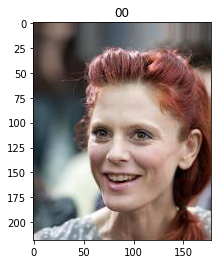

In [8]:
img = np.array(load_img(img_dir + img_paths[1]))
plt.title(str(attraction_df["Attractive"][1]) + str(attraction_df["Gender"][1]))
plt.imshow(img)
plt.show()

In [9]:
attraction_df['Partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: Partition, dtype: int64

In [10]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = cv2.resize(x, (224,224))
    x = x.reshape((1,) + x.shape)

    return x

In [11]:
def generate_df(partition,training_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    df_ = attraction_df[(attraction_df['Partition'] == partition)].sample(int(training_samples))
    
    x_ = np.array([load_reshape_img(img_dir + img_paths[i]) for i in tqdm(range(len(list(df_.image_id))))])
    x_ = x_.reshape(x_.shape[0], 224, 224, 3)
    y_gender = np_utils.to_categorical(df_["Gender"], 2)
    y_attractive = np_utils.to_categorical(df_["Attractive"], 2)

    return x_, y_gender, y_attractive

In [12]:
gender_list = ["Female", "Male"]
attractive = ["Not Attractive", "Attractive"]

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import applications

In [14]:
INPUT_SHAPE = (224,224,3)
BATCH_SIZE = 32
NUM_EPHOCHS = 20
LEARNING_RATE = 0.0001
TRAINING_SAMPLES = 8000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000

In [15]:
x_train, gender_y_train, attractive_y_train = generate_df(0, TRAINING_SAMPLES)

In [16]:
x_train.shape, gender_y_train.shape, attractive_y_train.shape

((8000, 224, 224, 3), (8000, 2), (8000, 2))

In [17]:
x_val, gender_y_val, attractive_y_val = generate_df(1, VALIDATION_SAMPLES)

In [18]:
x_test, gender_y_test, attractive_y_test = generate_df(2, TEST_SAMPLES)

In [19]:
mobilenetv2 = MobileNetV2(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

In [20]:
# mobilenetv2.summary()

In [21]:
def create_model():
    model = models.Sequential()
    model.add(mobilenetv2)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation="softmax"))
    
    return model

In [22]:
gender_model = create_model()

In [23]:
# learning rate scheduling
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE,
                                                         decay_steps=len(x_train)//BATCH_SIZE*5,
                                                         decay_rate=0.5,
                                                         staircase=True)

In [24]:
gender_model.compile(optimizer=Adam(lr_schedule),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [25]:
gender_train_datagen = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    )

# gender_val_datagen = ImageDataGenerator(
#     rescale=1./255.
# )

In [26]:
gender_train_generator = gender_train_datagen.flow(x_train, 
                                                   gender_y_train, 
                                                   batch_size=BATCH_SIZE)

# gender_val_generator = gender_val_datagen.flow(x_val, 
#                                                gender_y_val, 
#                                                batch_size=BATCH_SIZE)

In [27]:
validation_steps = x_val.shape[0]

In [28]:
gender_history = gender_model.fit(gender_train_generator,
                                  steps_per_epoch=len(gender_train_generator),
                                  epochs=NUM_EPHOCHS,
                                  validation_data=(x_val, gender_y_val),
                                  validation_steps=validation_steps)

Epoch 1/20
250/250 [==============================] - 115s 419ms/step - loss: 0.8000 - accuracy: 0.5345 - val_loss: 0.7221 - val_accuracy: 0.5500
Epoch 2/20
250/250 [==============================] - 104s 415ms/step - loss: 0.6858 - accuracy: 0.5843 - val_loss: 0.7410 - val_accuracy: 0.5815
Epoch 3/20
162/250 [==================>...........] - ETA: 33s - loss: 0.6789 - accuracy: 0.5783

KeyboardInterrupt: ignored

In [ ]:
attractive_model = create_model()

In [ ]:
attractive_model.compile(optimizer=Adam(lr_schedule),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
attractive_train_datagen = ImageDataGenerator(
    zoom_range=0.1,
    rescale=1./255.,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    )

attractive_val_datagen = ImageDataGenerator(
    rescale=1./255.
)

In [ ]:
attractive_train_generator = attractive_train_datagen.flow(x_train, 
                                                   attractive_y_train, 
                                                   batch_size=BATCH_SIZE)

attractive_val_generator = attractive_val_datagen.flow(x_val, 
                                               attractive_y_val, 
                                               batch_size=BATCH_SIZE)

In [ ]:
attractive_history = attractive_model.fit(attractive_train_generator,
                                  steps_per_epoch=len(attractive_train_generator),
                                  epochs=NUM_EPHOCHS,
                                  validation_data=attractive_val_generator,
                                  validation_steps=len(attractive_val_generator))